## Análise de Comunidades Baseada no Foursquare

### Disciplina: análise de redes sociais

### Equipe:
* Henrique Lima
* Julio Sales
* Mácio Matheus
* Victor Outtes

In [1]:
# !pip install python-louvain

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import json
import itertools
from pandas.io.json import json_normalize
import community

## 1. Coleta de dados

A coleta foi feita utilizando a API fornecida pelo Foursquare. Ela necessita de 2 parâmetros para ser acessada, o CLIENT ID e o CLIENT SECRETE, que podem ser obtidos ao se cadastrar como desenvolvedor no site da ferramenta.

O acesso que utilizamos utiliza coordenadas do local desejado e um raio de busca para encontrar os estabelecimentos mais curtidos. Esta foi a base da consulta.

Após isto, fazemos mais uma consulta: coletar os usuários que deram curtidas em todos os estabelecimentos obtidos. Juntando as 2 bases, conseguimos gerar um CSV. A partir dele que tudo será feito.

#### Função auxiliar para obter a categoria do local

In [3]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    return categories_list[0]['name']

#### Dados básicos utilizados nas consultas

In [4]:
CLIENT_ID = '55LWIFZLZNZPSTAZZQKJXBD11BSBCUZTZPIXWVV4RFZJP1HS' # your Foursquare ID
CLIENT_SECRET = 'RPCOWGHQY5YNQUCHQUTC5VLKEYFGZN15FSIYTK5GNXNZ301E' # your Foursquare Secret
VERSION = '20180604'
latitude_nyork = 40.785091
longitude_nyork = -73.968285
radius = 10000
LIMIT = 100

#### Obtem a lista de locais

In [5]:
QUERY = ''
url = 'https://api.foursquare.com/v2/venues/explore?time=any&query={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    QUERY, CLIENT_ID, CLIENT_SECRET, latitude_nyork, longitude_nyork, VERSION, radius, LIMIT)
results = requests.get(url).json()
locais = results['response']['groups'][0]['items']
locais_proximos = json_normalize(locais)
filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
locais_proximos = locais_proximos.loc[:, filtered_columns]
locais_proximos.columns = [col.split(".")[-1] for col in locais_proximos.columns]
locais_proximos['categories'] = locais_proximos.apply(get_category_type, axis=1)
locais_proximos.tail(10)

,id,name,categories,lat,lng
90,51c080d9abd88bfe62869a59,sweetgreen,Salad Place,40.744802,-73.988644
91,45940e37f964a52055401fe3,Kalustyan's,Gourmet Shop,40.742832,-73.982267
92,56e202d1498eb4f0d9ffcd68,Covina,Mediterranean Restaurant,40.742641,-73.983214
93,424de080f964a520aa201fe3,Museum of the Moving Image,Museum,40.756051,-73.923989
94,4a7b7f02f964a52037eb1fe3,Canoe Studios,Event Space,40.751750,-74.006765
95,4aeddba9f964a52096cf21e3,"Sal, Kris & Charlie's Deli",Sandwich Place,40.773304,-73.911434
96,40b68100f964a5207d001fe3,Madison Square Park,Park,40.742262,-73.988006
97,442e41b2f964a520da311fe3,Gagosian Gallery,Art Gallery,40.749493,-74.006050
98,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623
99,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205


#### Para cada local pega as curtidas

In [6]:
checkins_locais = pd.DataFrame()
for i,local in locais_proximos.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}&limit={}'.format(
    local['id'], CLIENT_ID, CLIENT_SECRET, VERSION, 10000)
    results = requests.get(url).json()
    if (results['response']['likes']['count'] > 0) & ('items' in results['response']['likes']):
        results_2 = results['response']['likes']['items']
        checkins = json_normalize(results_2)[['id', 'firstName', 'gender']]
        checkins['avenue_id'] = local['id']
        checkins['avenue_name'] = local['name']
        checkins['avenue_categories'] = local['categories']
        checkins['avenue_lat'] = local['lat']
        checkins['avenue_lng'] = local['lng']
        if checkins_locais.empty:
            checkins_locais = checkins
        else:
            checkins_locais = pd.concat([checkins_locais, checkins], ignore_index=True)

In [7]:
# checkins_locais.to_csv('likes_NY_geral.csv', index=False)
checkins_locais = pd.read_csv('likes_NY_geral.csv')
checkins_locais.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
120873,155281,Eric,male,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120874,75374383,Corinne,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120875,23147845,Lindsey,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120876,15370863,Julie,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120877,76392,Sara,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205


## 2. Pré-processamento dos dados

#### Filtragens

Aqui pegamos os locais com até 650 curtidas, para evitar pegar locais mais famosos que todo mundo vai. O ideal é utilizar a base toda, mas por questões de infraestrutura para processamento decidimos este caminho.

In [8]:
locais_vc = checkins_locais['avenue_id'].value_counts()
locais_filter = locais_vc[locais_vc <= 650].index.tolist()
len(locais_filter)

62

Retirando da base de dados apenas os locais identificados acima...

In [9]:
likes_completo = checkins_locais[checkins_locais['avenue_id'].isin(locais_filter)]

Aqui filtramos da base anterior só os usuários que deram pelo menos 2 curtidas em algum lugar. Isto serve para reduzir bastante a quantidade de usuários que serão os nós do grafo.

Depois disto, pegamos a lista de locais distintos obtidos depois desses 2 filtros.

In [10]:
vc = likes_completo['id'].value_counts()
filter = vc[vc >= 2].index.tolist()
usuarios_unicos = likes_completo[likes_completo['id'].isin(filter)]['id'].drop_duplicates()
usuarios_unicos = usuarios_unicos.tolist()
locais_unicos = likes_completo[likes_completo['id'].isin(filter)]['avenue_id'].drop_duplicates()
locais_unicos = locais_unicos.tolist()
len(locais_unicos)

62

## 3. Criação do grafo

Aqui segue a criação do grafo. Primeiro criamos os nós com os atributos de cada usuário. Após, para cada local selecionado, pegamos a listagem de usuários que deram curtida e fazemos uma combinação 2 a 2 para criar as arestas. 

Se a aresta entre dois nós não existe ela é criada com peso 1. Se já existe, o peso é incrementado em 1.

In [11]:
if False:
    grafo = nx.Graph()
    for usuarios in usuarios_unicos:
        grafo.add_node(str(usuarios), 
               nome=likes_completo[likes_completo['id']==usuarios]['firstName'].values[0],
               genero=likes_completo[likes_completo['id']==usuarios]['gender'].values[0])
    for local in locais_unicos:
        # pessoas que deram like...
        pessoas = list(likes_completo[
            (likes_completo['avenue_id'] == local) & (likes_completo['id'].isin(filter))
        ]['id'].drop_duplicates().values)
        combinacoes = itertools.combinations(pessoas, 2)
        for comb in combinacoes:
            u = comb[0]
            outro = comb[1]
            if grafo.has_edge(str(u), str(outro)):
                grafo[str(u)][str(outro)]['weight'] = grafo[str(u)][str(outro)]['weight'] + 1
            else:
                grafo.add_edge(str(u), str(outro), weight=1)

In [12]:
# nx.write_gml(grafo, 'grafo_new_york.gml')
grafo = nx.read_gml('grafo_new_york.gml')

## 4. Análise básica

Número de nós

In [13]:
nx.number_of_nodes(grafo)

2429

Número de arestas

In [14]:
nx.number_of_edges(grafo)

455374

Grau médio

In [15]:
np.mean([grau[1] for grau in list(nx.degree(grafo, weight='weight'))])

419.30177027583369

Centralidade de grau média

In [16]:
np.mean(list(nx.degree_centrality(grafo).values()))

0.15442657129699272

Centralidade de autovetor média

In [17]:
np.mean(list(nx.eigenvector_centrality(grafo, weight='weight').values()))

0.016740407531903336

Centralidade de proximidade média

In [18]:
np.mean(list(nx.betweenness_centrality(grafo, weight='weight').values()))

0.00035560575373295918

Coeficiente de cluster médio

In [19]:
nx.average_clustering(grafo, weight='weight')

0.06692713689234844

Excentricidade média

In [20]:
np.mean(list(nx.eccentricity(grafo).values()))

2.4594483326471801

## 5. Visualização

Calcula o posicionamento dos nós

In [21]:
pos = nx.spring_layout(grafo)

Desenha o grafo. As cores são formadas a partir das medidas de centralidade de grau de cada nó. Os tamanhos são definidos proporcionalmente às medidas de centralidade de autovetor de cada nó.

(-1.0789137617500018,
 0.65199943886339884,
 -0.61959839101650627,
 0.61963142606027566)

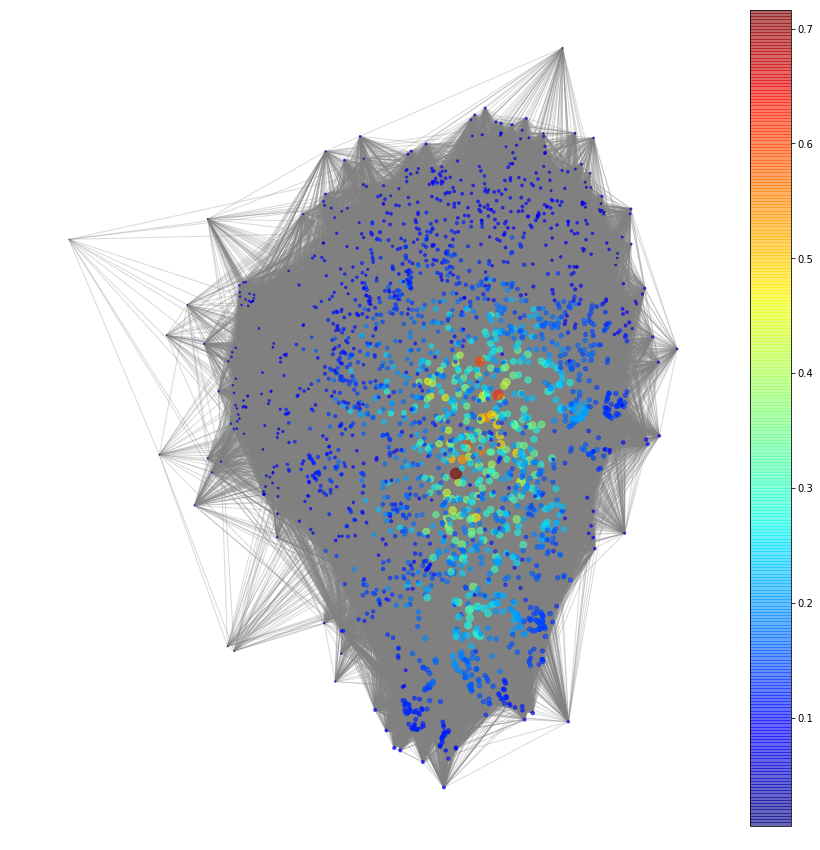

In [22]:
node_color = [cent for cent in nx.degree_centrality(grafo).values()]
node_size = [eigen * 1000 for eigen in list(nx.eigenvector_centrality(grafo, weight='weight').values())]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.3, edge_color='gray')
no = nx.draw_networkx_nodes(grafo, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=min(list(nx.degree_centrality(grafo).values())), 
                            vmax=max(list(nx.degree_centrality(grafo).values())),
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')

![network](https://raw.githubusercontent.com/macio-matheus/analysis-geospatial-data/develop/docs/network.png)

## 6. Detecção de comunidades

Para detectar as eventuais comunidades da rede utilizamos a biblioteca <strong>python-louvain</strong>. Ele define as comunidades com apenas a linha de código a seguir:

In [23]:
partition = community.best_partition(grafo, weight='weight')

Agora vamos desenhar o grafo de forma bem parecida com o anterior. Porém, agora, as cores serão as comunidades armazenadas na variável <strong>partition</strong>

(-1.0789137617500018,
 0.65199943886339884,
 -0.61959839101650627,
 0.61963142606027566)

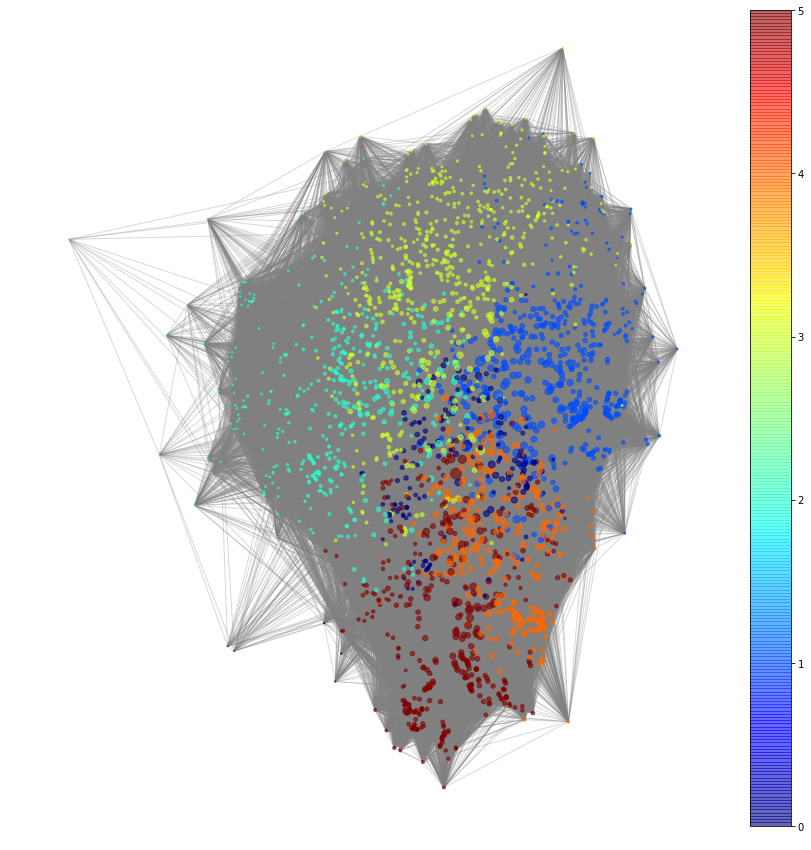

In [24]:
node_color = [partition.get(node) for node in grafo.nodes()]
node_size = [eigen * 1000 for eigen in list(nx.eigenvector_centrality(grafo, weight='weight').values())]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.3, edge_color='gray')
no = nx.draw_networkx_nodes(grafo, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=0.0, vmax=max(partition.values()),
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')

![community](https://raw.githubusercontent.com/macio-matheus/analysis-geospatial-data/develop/docs/community.png)

## 6.1. Análise das comunidades

A partir da definição dos grupos, podemos atualizar nossa base de dados inicial de curtidas com o grupo de cada usuário:

In [25]:
likes_completo['cluster'] = likes_completo['id'].apply(
    lambda x: partition[str(x)] if str(x) in list(partition.keys()) else None)
likes_com_cluster = likes_completo[~likes_completo['cluster'].isnull()]
likes_com_cluster.tail()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng,cluster
120843,79439436,Lauren,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205,3.0
120858,11928,David 🎉,male,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205,3.0
120860,1522042,Marie,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205,2.0
120868,1226733,Brittney,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205,3.0
120875,23147845,Lindsey,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205,2.0


In [26]:
#likes_com_cluster.to_csv('likes_NY_geral_cluster.csv', index=False)

Para cada comunidade detectada podemos ver quais foram os locais mais curtidos pelos usuários:

In [27]:
likes_com_cluster[likes_com_cluster['cluster'] == 0]['avenue_name'].value_counts()[:3]

Carl Schurz Park                        175
City Swiggers                            34
Jacqueline Kennedy Onassis Reservoir     30
Name: avenue_name, dtype: int64

In [28]:
likes_com_cluster[likes_com_cluster['cluster'] == 1]['avenue_name'].value_counts()[:3]

Bethesda Fountain                       239
Jacqueline Kennedy Onassis Reservoir    238
Bethesda Terrace                        104
Name: avenue_name, dtype: int64

In [29]:
likes_com_cluster[likes_com_cluster['cluster'] == 2]['avenue_name'].value_counts()[:3]

Sakagura                                149
KazuNori: The Original Hand Roll Bar    107
Equinox Rockefeller Center               92
Name: avenue_name, dtype: int64

In [30]:
likes_com_cluster[likes_com_cluster['cluster'] == 3]['avenue_name'].value_counts()[:3]

Park Avenue Armory         173
Vivian Beaumont Theater     80
Peloton                     70
Name: avenue_name, dtype: int64

In [31]:
likes_com_cluster[likes_com_cluster['cluster'] == 4]['avenue_name'].value_counts()[:3]

Gantry Plaza State Park      267
Hunter's Point South Park     97
Astoria Park                  41
Name: avenue_name, dtype: int64

In [32]:
likes_com_cluster[likes_com_cluster['cluster'] == 5]['avenue_name'].value_counts()[:3]

Astoria Park    172
Milkflower      170
Il Bambino      162
Name: avenue_name, dtype: int64

Também podemos encontrar as pessoas mais influentes da rede, pegando os nós com maior centralidade:

In [33]:
influentes = []
dic = nx.degree_centrality(grafo)
for v in sorted(dic, key=dic.get, reverse=True):
    influentes.append(v)
likes_com_cluster[likes_com_cluster['id'].isin(influentes[:10])][['firstName', 'gender', 'cluster']].drop_duplicates()

,firstName,gender,cluster
8339,JRA,none,3.0
8340,Alex,male,0.0
8401,Emily,female,5.0
8554,Kino,male,5.0
8787,John,male,1.0
8799,Philip,male,1.0
8823,Carolyn,female,1.0
28896,Garrett,male,4.0
35586,Nathan,male,5.0
35649,Dmtiry,male,4.0
